# SUDOKU lösen mit diversen Quanten Computing Ansätzen

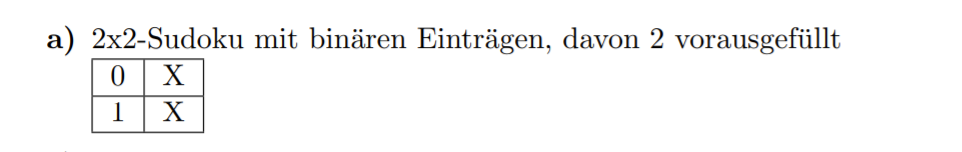

In [19]:
import utils
import numpy as np

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

## Variablen Deklaration:
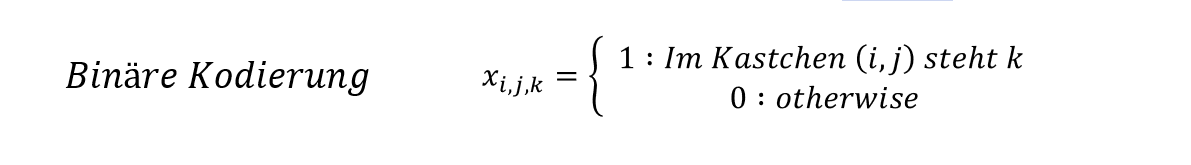

In [20]:
row_num = 2
column_num = 2
k_max = max(row_num, column_num)

num_sub_row = 1
num_sub_column = 1
block_size = 2

In [21]:
#Gewichte für Penalty funktions

alpha = 1
beta = 2
gamma = 2
delta = 0

In [22]:
# known values
known_vars = {}

known_vars[(0,0)] = 0
known_vars[(1,0)] = 1

In [23]:
all_vars = utils.get_all_vars(row_num, column_num, k_max)
var_list = utils.get_unbekannte_vars(row_num, column_num, k_max, known_vars)
prunned_list = utils.get_prunned_vars(row_num, column_num, k_max, num_sub_row, num_sub_column, block_size, known_vars)

In [24]:
# prunned variable list
prunned_list = var_list


-------

# Constraints and Penalty functions

In [25]:
n = len(prunned_list)
QUBO = np.zeros((n,n))

### Constraint 1: A single cell can only have one number

$$
\sum_{k=1}^{9} X_{i j k}=1, \quad \forall i j \in \text {cell}
$$

#### Here, we introduce a penalty weight $\alpha$.

$$
\alpha \sum_{i j}\left(\sum_{k=1}^{9} x_{i j k}-1\right)^{2}
$$

In [26]:
QUBO = utils.h1_penalty(alpha, QUBO, prunned_list)
penalty = 'h1'
#utils.get_qubo_heatmap(QUBO, prunned_list, penalty)

### Constraint 2: Each column j can not have a duplicate number

$$
 \sum_{i} X_{i j k}=1, \quad \forall j \in \text { column }, \forall k \in K(K=\{1 . .9\})
$$

#### Here, we introduce a penalty weight $\beta$.

$$
\beta \sum_{k=1}^{9} \sum_{j}\left(\sum_{i} x_{i j k}-1\right)^{2}
$$

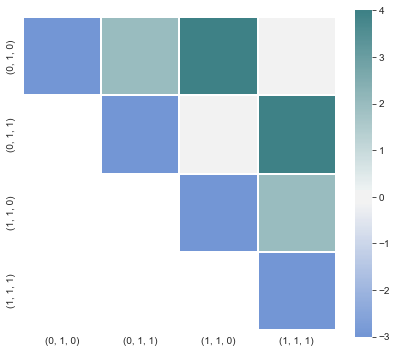

In [27]:
QUBO = utils.h2_penalty(beta, QUBO, prunned_list, all_vars, known_vars)
penalty = 'h2'
utils.get_qubo_heatmap(QUBO, prunned_list, penalty)

### Constraint 3: Each column row i cannot have any duplicate number

$$
 \sum_{j} X_{i j k}=1, \quad \forall i \in \text { row }, \forall k \in K(K=\{1 . .9\})
$$

#### Here, we introduce a penalty weight $\gamma$.

$$
\gamma \sum_{k=1}^{9} \sum_{i}\left(\sum_{j} x_{i j k}-1\right)^{2}
$$

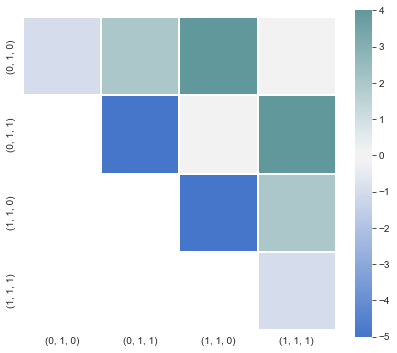

In [28]:
QUBO = utils.h3_penalty(gamma, QUBO, prunned_list, all_vars, known_vars)
penalty = 'h3'
utils.get_qubo_heatmap(QUBO, prunned_list, penalty)

### Constraint 4: Each of the subgrids cannot have any duplicate number

$$
\sum_{subgrid} x_{ijk}=1, \quad \forall k \in\{1 . .9\} \text{         } 
\forall subgrid 
$$


#### Here, we introduce a penalty weight $\delta$.

$$
\delta \sum_{k=1}^{9}\left(\sum_{subgrid} x_{ijk}-1\right)^{2}
$$

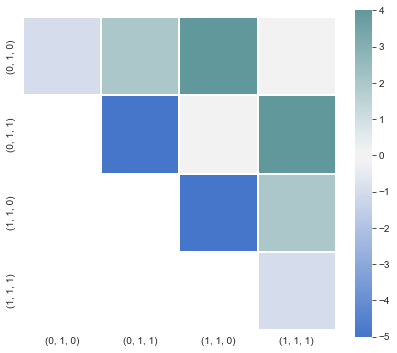

In [29]:
all_blocks = utils.get_all_blocks(num_sub_row, num_sub_column)
QUBO = utils.h4_penalty(delta, QUBO, prunned_list, all_vars, known_vars, block_size, all_blocks)
penalty = 'h4'
utils.get_qubo_heatmap(QUBO, prunned_list, penalty)

--------

# Lösung mit QBSolve (Simulated Annealing)

In [30]:
qubo_d = utils.matrix_to_dictionary(QUBO)

In [13]:
sampleset = utils.on_QBsolve(qubo_d)
first_sample = sampleset.samples()[0]
result = [y for _, y in first_sample.items()]

In [14]:
solution = utils.visualize_solution(row_num, column_num, prunned_list, known_vars, result)

print(solution)

[[0. 1.]
 [1. 0.]]


-----

# Lösung mit DWave (DWave Advantage)

In [16]:
sampleset = utils.on_DWave(QUBO, 1000)
first_sample = sampleset.samples()[0]
result = [y for _, y in first_sample.items()]

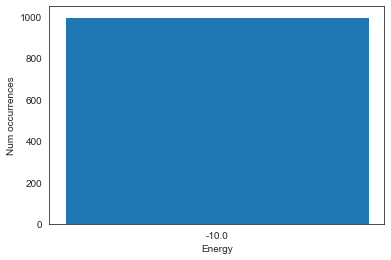

In [17]:
# Libraries
import numpy as np
import matplotlib.pyplot as plt

# Make a random dataset:
energies = sampleset.record.energy
num_occ = sampleset.record.num_occurrences
y_pos = np.arange(len(energies))

# Create bars
plt.bar(y_pos, num_occ)

# Create names on the x-axis
plt.xticks(y_pos, energies)
plt.xlabel('Energy')
plt.ylabel('Num occurrences')
# Show graphic
#plt.show()
plt.savefig('dwave.jpg')

In [ ]:
solution = utils.visualize_solution(row_num, column_num, prunned_list, known_vars, result)
print(solution)

----------

# Lösung mit QAOA (Qiskits QuadraticProgram)

In [34]:
quadr_program = utils.QUBO_to_QuadraticProgram(QUBO)
print(quadr_program)

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: CPLEX

Minimize
 obj: [ - 2 x0^2 + 4 x0*x1 + 8 x0*x2 - 10 x1^2 + 8 x1*x3 - 10 x2^2 + 4 x2*x3
      - 2 x3^2 ]/2
Subject To

Bounds
 0 <= x0 <= 1
 0 <= x1 <= 1
 0 <= x2 <= 1
 0 <= x3 <= 1

Binaries
 x0 x1 x2 x3
End



optimal params:       {ParameterVectorElement(θ[0]): 2.729120664612803, ParameterVectorElement(θ[1]): 5.697115686146415}
optimal value:        -3.448965714351914


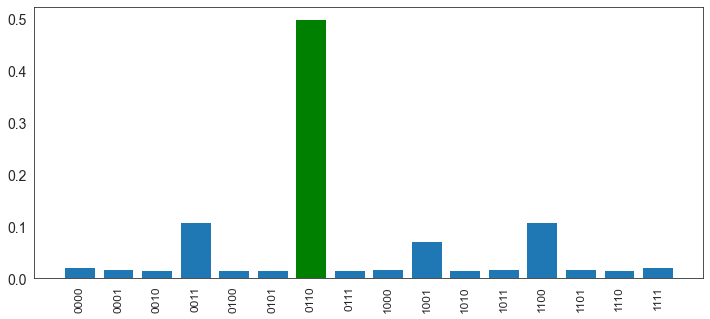

<generator object on_qiskit.<locals>.<genexpr> at 0x000001D672BED660>


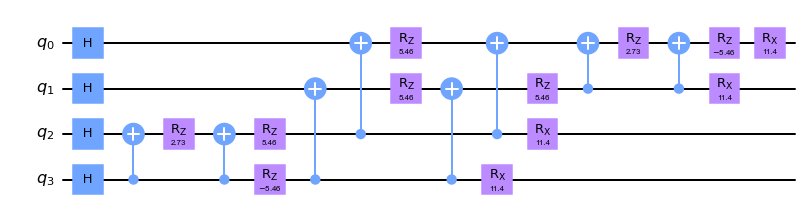

In [36]:
from qiskit import Aer
backend = Aer.get_backend('qasm_simulator')

qc = utils.on_qiskit(quadr_program, backend, with_graphic = True)[1]
display(qc.draw('mpl'))

## Kosten 

In [20]:
costs = utils.get_costs(qc)

OrderedDict([('u3', 16), ('cx', 8)])
Cost: 96


In [18]:
from qiskit import QuantumCircuit, Aer, assemble, IBMQ, transpile
for kk in range(4):
    trans_qc = transpile(qc, basis_gates=['cx', 'u3'], optimization_level=kk)
    
    #display(trans_qc.draw())
    print('Optimization Level {}'.format(kk))
    print('Depth:', trans_qc.depth())
    print('Gate counts:', trans_qc.count_ops())
    


Optimization Level 0
Depth: 14
Gate counts: OrderedDict([('u3', 16), ('cx', 8)])
Optimization Level 1
Depth: 13
Gate counts: OrderedDict([('u3', 15), ('cx', 8)])
Optimization Level 2
Depth: 13
Gate counts: OrderedDict([('u3', 15), ('cx', 8)])
Optimization Level 3
Depth: 13
Gate counts: OrderedDict([('u3', 15), ('cx', 8)])


In [ ]:
from qiskit import Aer
backend = Aer.get_backend('qasm_simulator')
counts = utils.measure_ciruit(qc, backend, shots = 1000)
result = counts.most_frequent()

In [ ]:
from qiskit.visualization import plot_histogram
plot_histogram(counts)

In [ ]:
solution = utils.visualize_solution(row_num, column_num, prunned_list, known_vars, result)
print(solution)